# Automatic Differentiation
## Introduction

In this tutorial, we will cover:

| Motivation<br>Computational graph<br>Propagating derivatives: forward and reverse AD<br>Generalizing the computational graph<br>The backpropagation algorithm<br>Custom automatic differentiation with PyTorch | <img src="https://miro.medium.com/v2/resize:fit:1400/1*NzyxsrkiLjjyjiIuCf123w.png" alt="Image" style="width: 50%;"> |
|:---:|---|



* Jacobians and Hessians with AD and PyTorch (Bonus)



In [1]:
# Setup
%matplotlib inline
import os
import sys
import time 
import torch
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 14
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Motivation

- In the last tutorial, we applied **first-order algorithms** to perform optimization.
- However, we haven't seen how to actually compute the gradients needed to apply them.
- Let $f: \mathbb{R}^d \rightarrow \mathbb{R}$. Suppose we want to compute its gradient at some point: $x^{(0)} \in \mathbb{R}^d$.
- Idea: use numerical differentiation:
    - Forward difference:
    $$ \left. \frac{\partial f}{\partial x_i} \right \vert_{x=x^{(0)}} \approx \frac{f(x^{(0)}_1,...,x_i^{(0)}+h,...,x^{(0)}_d)-f(x^{(0)})}{h} $$
        - Requires $d+1$ forward passes.
    - Central difference: 
        $$ \left. \frac{\partial f}{\partial x_i} \right \vert_{x=x^{(0)}} \approx \frac{f(x^{(0)}_1,...,x_i^{(0)}+h,...,x^{(0)}_d)-f(x^{(0)}_1,...,x_i^{(0)}-h,...,x^{(0)}_d)}{2h} $$
        - Requires $2d$ forward passes.

https://en.wikipedia.org/wiki/Numerical_differentiation

* Problems?
    + Inexact.
    + **Very expensive when the dimension is high!**

## Motivating example

- Let $f(x) = f_n \circ f_{n-1} \circ ... \circ f_1$ where $f_i: \mathbb{R} \rightarrow \mathbb{R}$ are functions that are easy to evaluate and differentiate.
    - More precisely, given $x=a$ we can compute $f_i(a)$ and $f_i'(a)$ in $\mathcal{O}(1)$.
    - Such function can be $x^c, sin(x), cos(x), exp(x)$ etc...
- Given $a$, how can we efficiently compute $f'(a)$?
- Using the chain rule, the derivative is given by:
$$ f'(a) = f_n'(f_{n-1}(f_{n-2}(...f_1(a))) \cdot ... \cdot f_2'(f_1(a)) \cdot f_1'(a) $$
- Naive algorithm:
    - Consider each term independently - $\mathcal{O}(n^2)$.
- Better approach (Dynamic Programming):
    - Let $F_j(x) := (f_j \circ ... \circ f_1)(x)$.
    - Compute and store $F_j(a)$ for each $1 \leq j \leq n-1$.
    - Afterwards, use the stored results to compute each term in the derivative in $\mathcal{O}(1)$.
    - Totally, $\mathcal{O}(n)$!
    
* Can we generalize what happend here?

## Computational graph

- The above computation can be viewed as a directed graph $G=(V,E)$, called a **computational graph**.
    
- In general, a computational graph is a directed acyclic graph (DAG) $G=(V,E)$.
- Each node has a:
    - Type (<span style="color:blue">input_variable</span>
/<span style="color:orange">input_constant</span>/`intermediate`/<span style="color:green">output</span>).
        - Type(v) is `input`(either variable or constant) iff $deg_{in}(v)=0$.
            - Variable if requires gradient computation (model parameters etc...)
                - Blue node.
            - Constant otherwise (hyper-parameters, $x$ in NN architectures, etc...)
                - Orange node.
            - In code, determine by setting ```.requires_grad``` field.
            - By default, False for tensors, True for built-in modules' parameters.
        - Type(v) is `output` iff $deg_{out}(v)=0$.
            - Green node.
        - Otherwise, `intermediate`.
            - Grey node.
    - Three fields: function (```.fn```), value (```.val```) and gradient (```.grad```).

In our case:
<center><img src="imgs/chain.png"/ height=70% width=70%> </center>

- For each node we associate a **value** (in our case - $F_j(a)$) which is computed via a process we name **forward pass**.
    - The values of the nodes are computed in a **topological order**.
    - Initialize: $v_0.val \leftarrow a$
    - Update: $v_{j+1}.val \leftarrow v_{j+1}.fn(v_j.val)$

<center><img src="imgs/chain_forward.png"/ height=70% width=70%> </center>

## Propagating derivatives: forward and reverse AD

- The derivative $\frac{d v_n}{d v_0}$ can be now computed by two DP approaches.
- Denote $D_{i,j} := \frac{dv_i}{dv_j}(F_j(a))$.
- First approach: by propagating the gradient from the input to the output.
    - Invariant: $v_j.grad = \frac{d v_j}{d v_0}(a)$.
    - Initialize: $v_0.grad \leftarrow 1$
    - Update grads in a **topological order**: $v_{j+1}.grad \leftarrow v_{j+1}.fn.derivative(v_j.val) \cdot v_j.grad$.
- This process is called **forward mode AD**!
        
<center><img src="imgs/chain_forwardAD.png"/ height=70% width=70%> </center>  

- Second approach: by propagating the gradient from the output to the input.
     - Invariant: $v_j.grad = \frac{d v_n}{d v_j}(F_j(a))$.
     - Initialize: $v_n.grad \leftarrow 1$
     - Update grads in a **reverse topological order**:
     $v_{j-1}.grad \leftarrow v_j.fn.derivative(v_{j-1}.val) \cdot v_j.grad$.   
- This process is called **reverse mode AD**!

<center><img src="imgs/chain_reverseAD.png"/ height=70% width=70%> </center>

## Generalizing the computational graph

- Generalization: multiple input nodes and output nodes
    - Forward mode AD: each node has to store the gradient w.r.t all the **input** nodes.
    - Reverse mode AD: each node has to store the gradient of all the **output** nodes w.r.t the nodes.
- Q: which mode should be used for computing gradients?


- A: reverse! requires saving only one ```.grad``` per each parameter! 

- Generalization: intermediate nodes with multiple inputs and outputs!
    - Examples:
        - Addition/multiplication blocks with $k$ inputs
        - Vector addition/dot product
        - Vector elementwise operations
        - Matrix multiplication
 

* Denote by $\mathcal{N}_{in}(v)$ all the nodes incoming to $v$ and by $\mathcal{N}_{out}(v)$ all the nodes outgoing of $v$.
* When computing values (forward pass):
    - Update rule becomes: $v.val \leftarrow f_v(\mathcal{N}_{in}(v).val)$

- When computing gradients:
    - Consider partial derivatives for intermediate noeds with multiple inputs.
    - Sum the update rule of the ```.grad``` field along inputs (in forward mode) and outputs (in reverse mode).
    - Forward mode AD update becomes: $v.grad \leftarrow \sum_{u \in \mathcal{N}_{in}(v)} \frac{\partial f_v}{\partial u}(\mathcal{N}_{in}(v).val) \cdot u.grad$. 
    

- Reverse mode AD update becomes: $v.grad \leftarrow \sum_{w \in \mathcal{N}_{out}(v)} \frac{\partial f_w}{\partial v}(\mathcal{N}_{in}(w).val) \cdot w.grad$. 
    - For each $w \in \mathcal{N}_{out}(v)$ note that $\frac{\partial f_w}{\partial v}(\mathcal{N}_{in}(w).val) \cdot w.grad$ note that can be precomputed and stored on the edge $e=(v,w)$.
    - Then, to compute $v.grad$, just sum the outgoing edges.
    - Compute $\frac{\partial f_v}{\partial u}(\mathcal{N}_{in}(v).val) \cdot v.grad$ for each $u \in \mathcal{N}_{in}(v)$ and stoe it on the edge $e=(u,v)$ to be used by the ingoing nodes.
        
<center><img src="imgs/backprop-modular.png" width="700"/></center>

### Example

- Consider the function $f(x,y)=sin(xy)+e^{xy}$. 
- Compute its gradient at $(x,y)=(1,2)$ using:
    - Manual differentiation.
    - Forward mode AD. 
    - Reverse mode AD.

- Manual:
$$ \frac{\partial}{\partial x} f(x,y) = y cos(xy) + y e^{xy} \rightarrow \frac{\partial}{\partial x} f(1,2) = 2cos(2)+2e^2 $$
$$ \frac{\partial}{\partial y} f(x,y) = x cos(xy) + x e^{xy} \rightarrow \frac{\partial}{\partial y} f(1,2) = cos(2)+e^2 $$
Hence the gradient at $(1,2)$ is $(2cos(2)+2e^2,cos(2)+e^2)$.

- For the automatic modes, let's build a computational graph for $f$!
    - Make sure that the nodes are topologically.

    <center><img src="imgs/example_graph.png" width="700"/></center>

- Let's perform a forward pass!
    - Begin by initializing the ```.val``` fields of the input nodes.
    - Process the nodes by their order.
    - Update the ```.val``` field by applying the function in the ```.fn``` field to the incoming nodes.
        
     <center><img src="imgs/example_forward.png" width="700"/></center>

- For the forward AD let's perform a forward gradient propagation!
    - Since there are two inputs, should repeat the process twice.
    - Begin by initializing the ``` .grad ``` field of the revlevant **input** node to $1$ and the ```.grad ``` field of the other **input** nodes to $0$.
    - Process the nodes in their order
        - Compute the partial derivatives of the function in the node w.r.t their inputs.
        - For each input - multiply the computed derivative by the ```.grad``` field of the corresponding input.
        - Sum the "messages" from the input nodes to update ```.grad``` field of the node.
    - We will demonstrate the process for $x$.
        - The process for $y$ is left as an exercise to the reader.
        


<center><img src="imgs/example_forwardAD.png" width="700"/></center>

- For the reverse AD let's perform a reverse gradient propagation!
    - Since there is only one output in our case, the process is done only once!
    - Begin by:
        - Initializing the ``` .grad ``` field of the revlevant **output** nodes to $1$ and the ```.grad ``` field of the other **output** nodes to $0$.
        - Computing the partial derivatives of the function in the output nodes w.r.t their inputs
        - "Sending" the derivatives using the corresponding edges.
    - Process the nodes in a **reversed order**:
        - Sum the "messages" in the output edges to update the ```.grad``` field of the node.
        - Compute the partial derivatives of the function in the node w.r.t their inputs.
        - "send" the derivatives using the corresponding edges.
        


<center><img src="imgs/example_reverseAD.png" width="700"/></center>

## The backpropagation algorithm

- Essentially forward pass + reverse mode AD in the computational graph generated by a neural network.
- For this exact reason the ```.backward()``` method supports only **scalar outputs** (otherwise, should save gradient for each output...)
- PyTorch automatically builds computational graphs when at least one variable that requires gradient is created.
%- We will see later on an application for the forward mode AD...

## Custom automatic differentiation with PyTorch

We'll now learn how to extend PyTorch's `autograd` by defining our own custom nodes in the computation graph.

Lets first introduce a cousin of ReLU, the Exponential-Linear Unit (ELU) activation function:

$$
f(z) =
\begin{cases}
z, & z > 0\\
\alpha \left(e^{z}-1\right) & z \leq 0
\end{cases}
$$

We'll pretend PyTorch does not include this activation function and implement a custom version ourselves.

In [3]:
import torch
import torch.autograd as autograd
import torchviz

from torch import Tensor

First, we'll implement just the actual computation as a standalone function so that we can reuse it later.

In [4]:
def elu_forward(z: Tensor, alpha: float):
    elu_positive = z
    elu_negative = alpha * (torch.exp(z) - 1)
    elu_output = torch.where(z>0, elu_positive, elu_negative)
    return elu_output

A quick visualization to see what it looks like:

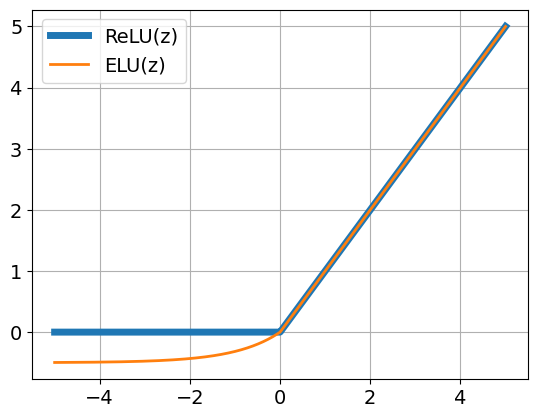

In [5]:
z = torch.linspace(-5, 5, steps=1000)
plt.plot(z.numpy(), torch.relu(z).numpy(), label='ReLU(z)', linewidth=5);
plt.plot(z.numpy(), elu_forward(z, alpha=.5).numpy(), label='ELU(z)', linewidth=2); plt.legend(); plt.grid();

Now we'll wrap it as an `nn.Module` so that we can use it as a layer in a model.

In [6]:
class ELU(torch.nn.Module):
    """ ELU Activation layer """
    
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, z: Tensor):
        return elu_forward(z, self.alpha)

And as usual, we can look at the resulting computation graph.

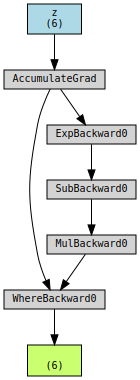

In [7]:
elu = ELU(alpha=0.5)
z = torch.tensor([-2., -1, 0, 1, 2, 3], requires_grad=True)
torchviz.make_dot(elu(z), params=dict(z=z))

We can see that the computation graph accurately represents the various basic mathematical operations performed by our `elu_forward` function.

But what if we want to define the entire ELU operarion as one node in the graph?
This can be useful e.g. for performance reasons or if pytorch can't differentiate through our layer.

How can we accomplish this?

The solution is to use a lower-level PyTorch API, `autograd.Function`
which allows us to define a function in terms of both it's forwards pass
(the regular output computation), and it's **backward** pass
(the gradient w.r.t. all its inputs).

From the PyTorch docs:
    
>Every operation performed on `Tensors`s creates a new `Function` object, that performs the computation, and records that it happened. The history is retained in the form of a DAG of functions, with edges denoting data dependencies (input <- output). Then, when backward is called, the graph is processed in the topological ordering, by calling `backward()` methods of each `Function` object, and passing returned gradients on to next `Function`s.

The API of an `autograd.Function` is:

```python
class MyCustomFunction(autograd.Function):
    
    @staticmethod
    def forward(context, *inputs: Tensor, **kw):
        ...
    
    @staticmethod
    def backward(context, *grad_outputs: Tensor) -> Sequence[Tensor]:
        ...
```

1. What do you think `grad_outputs` contains?
2. What does `backward()` need to return?
3. Why do we need a `context`?

To implement the ELU as an `autograd.Function`, we'll first calculate the simple analytic derivative of the ELU function:
$$
\frac{\partial f(z)}{\partial z} = f'(z) = 
\begin{cases}
1, & z > 0\\
\alpha e^{z} & z \leq 0
\end{cases}
$$

Next, we need to figure out how to compute the vector-Jacobian product efficiently.
Note that for any **elementwise** operation, $\vec{y}=f(\vec{x}),\ f:\mathbb{R}^n\rightarrow\mathbb{R}^n$, we can write the Jacobian as

$$
\frac{d \vec{y}}{d \vec{x}} = \pmatrix{
\ddots & \vdots & \\
\cdots & \frac{\partial y_i}{ \partial x_j} & \cdots \\
& \vdots & \ddots\\
}
=
\pmatrix{
f'(x_1) &  &  \\
  & f'(x_i) &  \\
& & f'(x_n)\\
}
= Diag\{{f'(\vec{x})}\}
$$

And it follows that the VJP can be computed simply:
$$
\delta \vec{x} = \delta{\vec{y}}\frac{\partial \vec{y}}{\partial \vec{x}} = \delta{\vec{y}} \odot f'(\vec{x}).
$$

Now, equipped with the expression for the VJP, we can proceed to implement the `Function` object representing ELU.

In [8]:
class ELUFunction(autograd.Function):
    
    @staticmethod
    def forward(ctx, z: Tensor, alpha: float):
        elu = elu_forward(z, alpha) # Regular forward pass computation from before
        ctx.save_for_backward(z)    # Tensors should be saved using this method
        ctx.alpha = alpha           # other properties can be saved like so
        return elu
    
    @staticmethod
    def backward(ctx, grad_output):
        z, = ctx.saved_tensors      # Validates that no in-place modifications happened on saved tensors
        alpha = ctx.alpha
        
        # Calculate diagonal of d(elu(z))/dz
        grad_positive = torch.ones_like(z)
        grad_negative = alpha * torch.exp(z)
        
        # Note: This is not the full Jacobian, d(elu(z))/dz, it's the diagonal
        grad_elu = torch.where(z>0, grad_positive, grad_negative)

        # Gradient of the loss w.r.t. our output
        δ_elu = grad_output
        
        # Calcualte δz = d(elu(z))/dz * δ_elu
        # Note: elementwise multiplication equivalant to vector-Jacobian product
        δz = grad_elu * δ_elu
        return δz, None

We can now use this custom `Function` either directly or as part of a layer.

For example, here's an ELU layer using our custom backward:

In [9]:
class ELUCustom(torch.nn.Module):
    """ ELU Layer with a custom backward pass """
    
    def __init__(self, alpha: float = 0.1):
        super().__init__()
        self.alpha = alpha
    
    def forward(self, z: Tensor):
        # Function.apply() invokesa the forward pass with a new context
        # and updates the computation graph of the inputs
        return ELUFunction.apply(z, self.alpha)

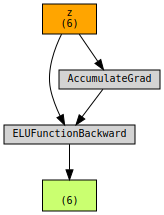

In [10]:
elu_custom = ELUCustom(alpha=0.5)
z = torch.tensor([-2., -1, 0, 1, 2, 3], requires_grad=True)
torchviz.make_dot(elu_custom(z), params=dict(z=z))

This only tested the forward pass. Let's now put our custom layer in the context of a larger model and see that we can backprop through it.

In [11]:
elu_mlp = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=1024,bias=False),
    ELUCustom(alpha=0.01),
    torch.nn.Linear(in_features=1024, out_features=1024),
    ELUCustom(alpha=0.01),
    torch.nn.Linear(in_features=1024, out_features=10),
    torch.nn.Softmax(dim=1)
)

elu_mlp

Sequential(
  (0): Linear(in_features=512, out_features=1024, bias=False)
  (1): ELUCustom()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): ELUCustom()
  (4): Linear(in_features=1024, out_features=10, bias=True)
  (5): Softmax(dim=1)
)

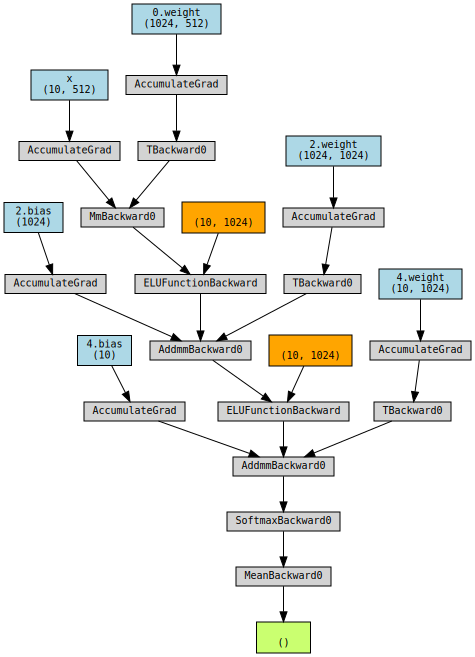

In [12]:
x = torch.randn(10, 512, requires_grad=True)
torchviz.make_dot(elu_mlp(x).mean(), params=dict(list(elu_mlp.named_parameters()) + [('x', x)]))

Let's run the backward pass and make sure we have gradients on all parameter tensors.

In [13]:
l = torch.sum(elu_mlp(torch.randn(10, 512, requires_grad=True)))
l.backward()

for name, param in elu_mlp.named_parameters():
    print(f"{name} {torch.norm(param.grad).item()}")

0.weight 2.0129235167587467e-07
2.weight 3.194509758941422e-07
2.bias 2.9578931304286016e-08
4.weight 3.4803895232471405e-07
4.bias 7.567952309273096e-08


## Jacobians and Hessians with AD and PyTorch (Bonus)

* In general, Jacobians and Hessains become very large for modern neural network architectures.
* Despite their **immense** computation and memory burdens, PyTorch still provides an API for their explicit computation:
    https://pytorch.org/functorch/stable/notebooks/jacobians_hessians.html

- However, in many cases we don't really need to compute the Jacobian or the Hessian by themselves.
- But rather products of the form $v^TJ$, $Jv$, $v^TH$, $Hv$ where:
    - $J$ is a Jacobian matrix of some outputs w.r.t model parameters.
    - $H$ is the Hessian matrix of model parameters.
    - $v$ is some constant vector.
- Such products can be carried efficiently both in theory and in PyTorch.

Let's set a model and input for the following code parts:

In [14]:
import torch.nn as nn

model = nn.Linear(100, 10)
x = torch.randn(5, 100)

### Vector-Jacobian Product (VJP)

- Let $f: \mathbb{R}^W \rightarrow \mathbb{R}^C$ be a function with multiple outputs,
with the model parameters an inputs.

- Its Jacobain matrix $J_f(w) \in \mathbb{R}^{C \times W}$. 

- Let $v \in \mathbb{R}^{C \times 1}$ be a **constant** column vector.

- Hence $v^TJ_f(w) \in \mathbb{R}^{1 \times W}$.

- Instead of computing directly can push the (constant) vector inside the derivative:
$$ v^TJ_f(w) = \nabla_w (v^T f)$$
- Compute like a regular gradient!
- Code example:

In [15]:
# Compute the Jacobian of the model outputs w.r.t model params multiplied by a constant vector

model_outs = model(x)
constant_vec = torch.randn((5, 10))

# Dot product trick
dot_prod = torch.dot(model_outs.reshape(-1),
                       constant_vec.reshape(-1))

# Compute grad
dot_prod.backward()

# Assert everything went ok 
for name, param in model.named_parameters():
    print(f"{name} {torch.norm(param.grad).item()}")

weight 59.592594146728516
bias 6.537693977355957


### Jacobian-Vector Product (JVP)

- Let $f: \mathbb{R}^W \rightarrow \mathbb{R}^C$ be a function with multiple outputs,
with the model parameters an inputs.

- Its Jacobain matrix $J_f(w) \in \mathbb{R}^{C \times W}$. 

- Let $v \in \mathbb{R}^{W \times 1}$ be a **constant** column vector.

- Hence $J_f(w)v \in \mathbb{R}^{C \times 1}$.

- Trick: consider $w(t) = w + vt$. Note that $w(0)=w$ and $\dot{w}(0)=v$.
- Consider now $g(t) := f(w(t))$. Note that $g: \mathbb{R} \rightarrow \mathbb{R}^C$.
- Note that $g(t)$ has a **single** input and **multiple** outputs, therby its derivative can be efficiently computed using a **forward mode AD**!
- Howerver, $\dot{g}(t) = J_f(w(t)) \cdot \dot{w}(t)$. In particular, $\dot{g}(0) = J_f(w) \cdot v$ which is exactly what we wanted to compute!
- In practice, we don't need to actually add $t$ to the computational graph.
    - Instead, just set the ```.grad``` of each parameter $w_i$ to be the corresponding entry of $v$, namely  $v_i$.
    - Then, propagate gradients forward as before.

* The PyTorch implementation of forward mode AD uses the context of dual numbers.
* Each dual number consists of primal (```.val``` in our implementation) and tangent (```.grad``` in our implementation).

In [16]:
# First, let's reset the gradients from the previous stage
for p in model.parameters():
    if p.requires_grad:
        p.grad = None

In [17]:
import torch.autograd.forward_ad as fwAD

params = {name: p for name, p in model.named_parameters()}
constant_vec = {name: torch.rand_like(p) for name, p in params.items()}

with fwAD.dual_level():
    
    # Manually set '.tangent' to propagate grads forward
    for name, p in params.items():
        delattr(model, name)
        setattr(model, name, fwAD.make_dual(p, constant_vec[name]))
    
    # Apply model
    out = model(x)
    
    # Extract the '.tangent' of the output node
    jvp = fwAD.unpack_dual(out).tangent
            
# Assert everything went ok 
print(f"JVP: {jvp}")

JVP: tensor([[ 12.9747,   5.1294,  10.9688,   8.9754,   8.5315,   6.5809,  10.1785,
          12.7517,   7.9965,   9.0048],
        [  0.1476,   3.3589,   0.6669,   5.4944,   7.9856,   6.1468,   3.6670,
           0.4737,  -0.4132,   5.0854],
        [ -2.2306,  -1.5348,  -0.3690,  -0.5163,  -0.6187,  -3.8976,   7.6771,
          -3.4724,  -0.1764,  -2.0414],
        [ -5.7417,  -9.9915, -10.9281,  -7.3273,  -7.7580,  -8.8694,  -6.7291,
          -7.1619,  -4.3795, -13.5380],
        [ -3.7550,  -1.5950,  -2.0433,   0.9276,   2.2509,  -3.8973,   2.5104,
           1.4369,  -3.9529,  -0.8301]], grad_fn=<AddBackward0>)


### Vector-Hessian and Hessian-Vector Products

- $f: \mathbb{R}^W \rightarrow \mathbb{R}$ be a single output function.
- Observation: the Hessian of $f$ is Jacobian of its gradient:
$$ \nabla^2 f = J( \nabla f )$$
- Therefore, like before, to compute vector-hessian product, one can push the vector inside the jacobian:
$$ v^T \nabla^2 f = v^T J( \nabla f) = \nabla ( v^T (\nabla f)) $$.
- Note that this requires constructing the computational graph of $\nabla f$!

In [18]:
# Reset model
model = nn.Linear(100, 10)

In [19]:
from torch.nn.functional import cross_entropy

constant_vec = [torch.randn_like(p) for p in model.parameters()]

# Apply model
out = model(x)
# Apply arbitrary loss function for a scalar output
loss = cross_entropy(out, 
                     torch.ones(x.shape[0]).type(torch.long))

# Compute gradient and create its computational graph
grad = torch.autograd.grad(loss, model.parameters(), create_graph=True)
# Flatten copy of the gradient to be used later
flat_grad = torch.cat([g.contiguous().view(-1) for g in grad])

# Flatten vector
flat_vec = torch.cat([v.contiguous().view(-1) for v in constant_vec])
dot_prod = torch.dot(flat_grad, flat_vec)

# Compute vhp
dot_prod.backward()

# Assert everything went ok 
for name, param in model.named_parameters():
    print(f"{name} {torch.norm(param.grad).item()}")

weight 17.78291893005371
bias 1.3691229820251465


* HVPs: essentially the same, left as an exercise to the reader.

## Credits

This tutorial was mostly written by Mitchell Keren Taraday.

The "Custom automatic differentiation with PyTorch" chapter is taken from Aviv A. Rosenberg's tutorial.

Image credits:
- https://en.wikipedia.org/wiki/Automatic_differentiation